# Time Series Revenue Forecast for Marketing Channel w/ PyTorch LSTM Neural Network

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

%matplotlib inline

Import and join of CSV Files

In [5]:
dfA = pd.read_csv('table_A_conversions.csv')
dfB = pd.read_csv('table_B_attribution.csv')

In [8]:
join_df = pd.merge(dfA, dfB, on='Conv_ID', how='inner')

In [11]:
join_df['Conv_Date'] = pd.to_datetime(join_df['Conv_Date'])

In [249]:
join_df['Revenue'].sum()/join_df['User_ID'].nunique()

697.9706068885996

Selecting rows that have marketing channel A. It is the channel with the most conversions and revenue, so it is a good example for this case.

In [180]:
dfchA = join_df.loc[join_df['Channel'] == 'A']

Grouping and aggregating the sum of the revenue over the dates

In [177]:
grpA = dfchA[['Conv_Date', 'Revenue']].groupby(['Conv_Date']).sum()
grpA['Revenue'] = grpA['Revenue'].astype(int)

Using Isolation Forest implementation to identify and remove outliers.

In [184]:
clf = IsolationForest(max_samples=500)
grpA['anomaly'] = clf.fit_predict(grpA['Revenue'].to_numpy().reshape(-1,1))
grpA = grpA.loc[grpA['anomaly'] == 1]

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:281: UserWarning: max_samples (500) is greater than the total number of samples (389). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


Plotting each day's total revenue over all days.

In [186]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

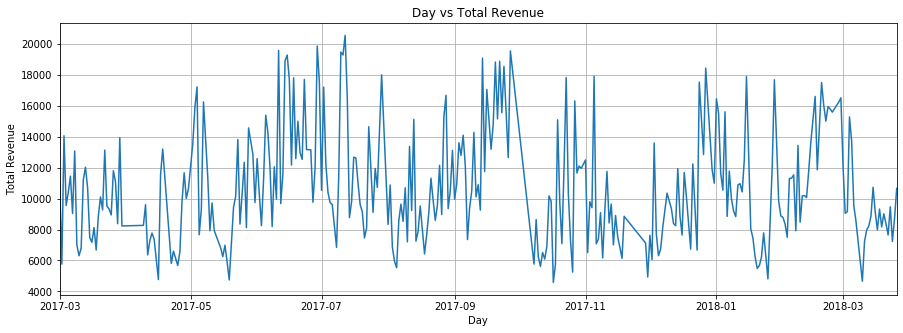

In [187]:
plt.title('Day vs Total Revenue')
plt.ylabel('Total Revenue')
plt.xlabel('Day')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(grpA['Revenue'])

Preparing data for time series prediction w/ LSTM NN

In [188]:
revenue_data = grpA['Revenue'].values

The test data will contain 82 days worth of data, which represents 25% of all data.

In [189]:
test_data_size = int(len(revenue_data)*0.25)
test_data_size

82

In [190]:
train_data = revenue_data[:-test_data_size]
test_data = revenue_data[-test_data_size:]

Scaling data for easier handling and improving predictive performance

In [191]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(revenue_data .reshape(-1, 1))

In [192]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

The in_out_seqsfunction will accept the raw input data and will return a list of tuples. In each tuple, the first element will contain list of 10 items corresponding to the sum of revenues in 10 days, the second tuple element will contain one item - the sum of revenue on the 10th+1st day.

In [234]:
train_window = 10

In [208]:
def in_out_seqs(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [235]:
train_inout_seq = in_out_seqs(train_data_normalized, train_window)

input_size: Corresponds to the number of features in the input. Though our sequence length is 10, for each day we have only 1 value - the total sum of revenue, therefore the input size will be 1.

hidden_layer_size: Specifies the number of hidden layers along with the number of neurons in each layer. We will have one layer of 100 neurons.

output_size: The number of items in the output, since we want to predict the total sum of revenue for 1 day in the future, the output size will be 1.

in the constructor we create variables hidden_layer_size, lstm, linear, and hidden_cell. LSTM algorithm accepts three inputs: previous hidden state, previous cell state and current input. The hidden_cell variable contains the previous hidden and cell state. The lstm and linear layer variables are used to create the LSTM and linear layers.

Inside the forward method, the input_seq is passed as a parameter, which is first passed through the lstm layer. The output of the lstm layer is the hidden and cell states at current time step, along with the output. The output from the lstm layer is passed to the linear layer. The predicted number of passengers is stored in the last item of the predictions list, which is returned to the calling function.

In [210]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

The next step is to create an object of the LSTM() class, define a loss function and the optimizer. Since, we are solving a regression problem, we will use the mean squared error loss. For the optimizer function, we will use the adam optimizer.


In [236]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Model training is 600 epochs, with the loss printed out every 50th epoch. As you can see, probably more epochs and some parameter tuning is needed for better convergence, but for this show

In [237]:
epochs = 600

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%50 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.02058357
epoch:  51 loss: 0.02239211
epoch: 101 loss: 0.00706952
epoch: 151 loss: 0.00004033
epoch: 201 loss: 0.00504816
epoch: 251 loss: 0.00036532
epoch: 301 loss: 0.01649605
epoch: 351 loss: 0.00088329
epoch: 401 loss: 0.00006293
epoch: 451 loss: 0.00266899
epoch: 501 loss: 0.00003950
epoch: 551 loss: 0.00056521
epoch: 599 loss: 0.0005458191


Since our test set contains the revenue data for the last 82 days and our model is trained to make predictions using a sequence length of 82. We will first filter the last 82 values from the training set:

In [238]:
fut_pred = test_data_size
test_inputs = train_data_normalized[-train_window:].tolist()

In [239]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

Since we normalized the dataset for training, the predicted values are also normalized. We need to convert the normalized predicted values into actual predicted values. We can do so by passing the normalized values to the inverse_transform method of the min/max scaler object that we used to normalize our dataset.

In [240]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

In [241]:
x = np.arange(248, 330, 1)

In [219]:
grpA.reset_index(inplace=True)

The predictions made by our LSTM are depicted by the orange line. You can see that our algorithm is not too accurate but still it has been able to capture the trend for total daily revenue in the last 82 days along with occasional fluctuations. You can try with a greater number of epochs and with a higher number of neurons in the LSTM layer to see if you can get better performance.

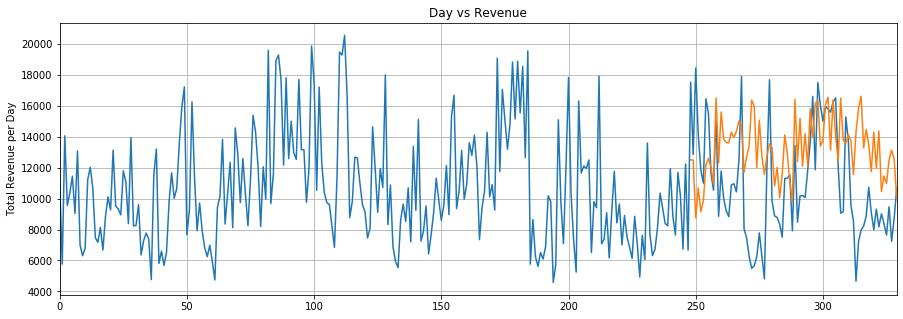

In [245]:
plt.title('Day vs Revenue')
plt.ylabel('Total Revenue per Day')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(grpA['Revenue'])
plt.plot(x,actual_predictions)
plt.show()

Again, the predictions are not very accurate but the algorithm was able to capture the daily channel revenues movements in the future days with occasional fluctuations.

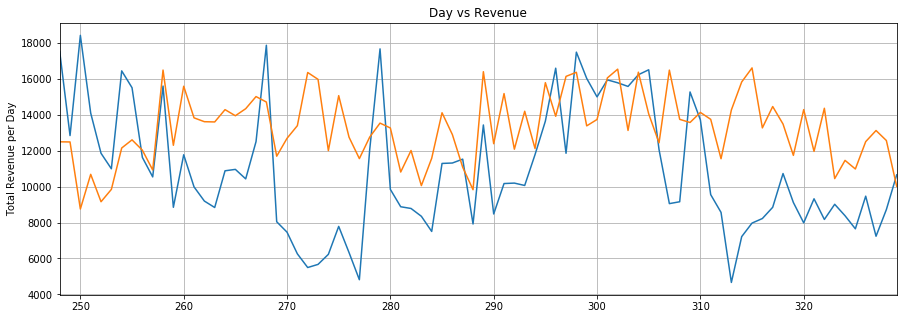

In [243]:
plt.title('Day vs Revenue')
plt.ylabel('Total Revenue per Day')
plt.grid(True)
plt.autoscale(axis='x', tight=True)


plt.plot(grpA['Revenue'][-test_data_size:])
plt.plot(x,actual_predictions)
plt.show()